<h2 style='text-align: center'> Analyzing the text dataset </h2>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("new_text_dataset.tsv", sep='\t', encoding="utf-8")
titles = [text for text in df.title]
len(titles)

56400

In [3]:
max_len = 0
titles_len = []

for title in titles:
  titles_len.append(len(title.split()))
  max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))

Number of titles: 56400
Max length of the titles: 59
Mean length of the titles: 7.958989361702128


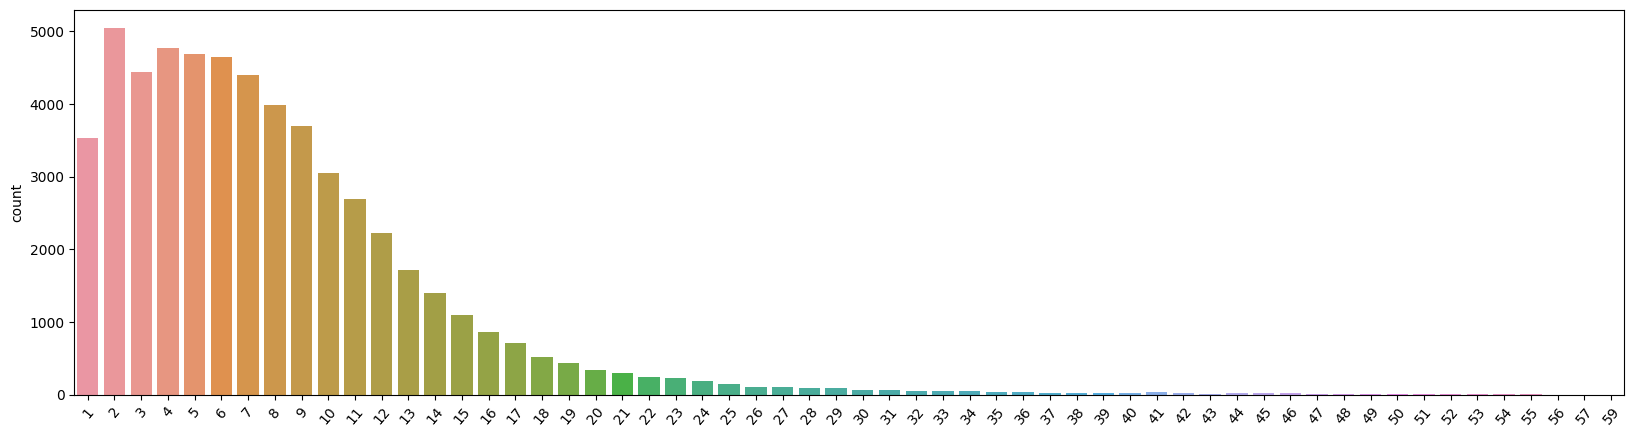

In [4]:
plt.figure(figsize=(20,5))
g = sns.countplot(x=titles_len)
g.set_xticklabels(g.get_xticklabels(), rotation=50)
plt.show()

In [5]:
from sklearn.utils import shuffle
df = df.drop(['Unnamed: 1'], axis = 1)
df = df[['6_way_label', 'title']]
df = shuffle(df).reset_index(drop=True)
display(df)

,6_way_label,title
0,0,PsBattle: Two tigers fighting
1,2,Rebellious youth invokes the nazi salute at th...
2,0,Bird T-Posing to show dominance
3,4,Da Bears!
4,0,This restaurant in Korea had a Christmas tree ...
...,...,...
56395,1,‘I Draw A Dinosaur On The Stomach Of Every Pre...
56396,4,Not very well done attempt
56397,4,"""Watch out, damn dragons could swoop down at a..."
56398,2,This derelict house


<h2 style='text-align: center'> Forming the training, testing and validation dataset </h2>

In [6]:
train_val_df = df.sample(frac = 0.8)
test_df = df.drop(train_val_df.index)

train_df = train_val_df.sample(frac = 0.8)
val_df = train_val_df.drop(train_df.index)

# Reset Index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('trainset size:', train_df.shape)
print('valset size:', val_df.shape)
print('testset size:', test_df.shape)

trainset size: (36096, 2)
valset size: (9024, 2)
testset size: (11280, 2)


In [7]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

In [8]:
nlp_df = pd.concat([train_df, val_df, test_df])
nlp_df

,6_way_label,title
0,4,Competitive Sexual Reassignment Surgery
1,5,"""The Last Judgement"" by Pavel Ryzhenko, Russia..."
2,2,Two Chinese citizens drive around China (2019)
3,2,A Brain
4,4,Slenderboy
...,...,...
11275,2,Hippo-Saw?
11276,4,"In an attempt to spice things up, organizers a..."
11277,2,A squadron of Redditors fight to stop Anti-Net...
11278,0,PsBattle: This gray wolf eating a watermelon


<h2 style='text-align: center'> Applying the concepts of NLP </h2>

In [9]:
import nltk
# Downloading Stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [11]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result

In [12]:
import gensim

# Applying The Function To The Dataframe
df['clean'] = df['title'].apply(preprocess)

In [13]:
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

total_words = len(list(set(list_of_words)))
total_words

31794

In [14]:
from nltk import word_tokenize


In [15]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(train_df['title'])

train_sequences = tokenizer.texts_to_sequences(train_df['title'])
val_sequences = tokenizer.texts_to_sequences(val_df['title'])
test_sequences = tokenizer.texts_to_sequences(test_df['title'])

<h2 style='text-align: center'> Training the model </h2>

In [16]:
import torch
from transformers import BertTokenizer

In [17]:
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [18]:
from torch.utils.data import Dataset

class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer

    def __getitem__(self, idx):
        if self.mode == 'test':
            label, statement = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            label, statement = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)

        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)


        # tokens_b = self.tokenizer.tokenize(text_b)
        # word_pieces += tokens_b + ["[SEP]"]
        # len_b = len(word_pieces) - len_a

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)

        return (tokens_tensor, segments_tensor, label_tensor)

    def __len__(self):
        return self.len


# Initialize Datasets for Transformation
trainset = FakeNewsDataset('train', tokenizer=tokenizer)
valset = FakeNewsDataset('val', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)

print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 36096
valset size: 9024
testset size:  11280


In [19]:
sample_idx = 5

label, statement = trainset.df.iloc[sample_idx].values

tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)


print(f"""
original_statement:
{statement}

tokens:
{tokens}

label: {label}

--------------------

tokens_tensor:
{tokens_tensor}

segments_tensor:
{segments_tensor}

label_tensor:
{label_tensor}

""")



original_statement:
I pulled the ticket when it was printing and accidentally did this

tokens:
['[CLS]', 'i', 'pulled', 'the', 'ticket', 'when', 'it', 'was', 'printing', 'and', 'accidentally', 'did', 'this', '[SEP]']

label: 0

--------------------

tokens_tensor:
tensor([ 101, 1045, 2766, 1996, 7281, 2043, 2009, 2001, 8021, 1998, 9554, 2106,
        2023,  102])

segments_tensor:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

label_tensor:
0




In [20]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [21]:
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None

    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)

    return tokens_tensors, segments_tensors, masks_tensors, label_ids


BATCH_SIZE = 16
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [22]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape}
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([16, 42])
tensor([[  101,  6975,  4424,  2128, 12054, 24838,  5970,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  1000,  1996,  2197, 16646,  1000,  2011, 18635, 29431, 27922,
         17868,  1010,  3607,  1010,  2289,  1031,  3424,  1011,  2530,  1010,
          6244,  7988,  1033,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2048,  2822,  4480,  3298,  2105,  2859,  1006, 10476,  1007,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,

In [23]:
from transformers import BertForSequenceClassification
from IPython.display import display, clear_output

PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 6

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()


print("""
name             module
-----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:16} {}".format(name, module))


name             module
-----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout          Dropout(p=0.1, inplace=False)
classifier       Linear(in_features=768, out_features=6, bias=True)


In [24]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [25]:
# %%time
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
NUM_EPOCHS = 3

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()

        outputs = model(input_ids=tokens_tensors,
                        token_type_ids=segments_tensors,
                        attention_mask=masks_tensors,
                        labels=labels)

        loss = outputs[0]
        loss.backward()
        optimizer.step()

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        train_loss += loss.item()

        # if batch_idx == len(trainloader)-1:
        #     _, acc = get_predictions(model, trainloader, compute_acc=True)

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

device: cuda


  0%|          | 0/2256 [00:00<?, ?it/s]

  0%|          | 0/2256 [00:00<?, ?it/s]

  0%|          | 0/2256 [00:00<?, ?it/s]

<h2 style='text-align: center'> Saving the Model </h2>

In [26]:
torch.save(model, 'week3.pth')

<h2 style='text-align: center'> Checking accuracy of the Model </h2>

[[0.90247934 0.026109  ]
 [0.09752066 0.973891  ]]
Acc:  0.8316489361702127


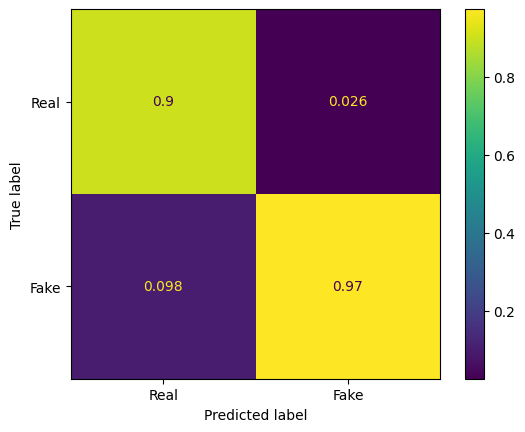

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true=[]
predictions=[]
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]

        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        test_outputs = model(input_ids=tokens_tensors,
                    token_type_ids=segments_tensors,
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())


cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot()

print('Acc: ', accuracy_score(predictions,true))

In [28]:
df = pd.DataFrame({"pred_label": predictions})

df_pred = pd.concat([testset.df.loc[:, ['title']], testset.df.loc[:, ["6_way_label"]], df.loc[:, 'pred_label']], axis=1)
# df_pred.to_csv('bert_1_prec_training_samples.csv', index=False)
df_pred

,title,6_way_label,pred_label
0,PsBattle: Two tigers fighting,0,0
1,PsBattle: World's oldest male twins,0,0
2,This urinal has a tiny golf flag to aim at,0,0
3,PsBattle: Dog lying in front of band,0,0
4,"Woman, 64, accused of erecting traps on North ...",0,0
...,...,...,...
11275,Hippo-Saw?,2,1
11276,"In an attempt to spice things up, organizers a...",4,0
11277,A squadron of Redditors fight to stop Anti-Net...,2,2
11278,PsBattle: This gray wolf eating a watermelon,0,0


In [29]:
from sklearn.metrics import classification_report
print(classification_report(df_pred['6_way_label'], df_pred.pred_label))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4374
           1       0.83      0.76      0.80       717
           2       0.79      0.64      0.71      2177
           3       0.72      0.57      0.64       252
           4       0.81      0.91      0.86      3344
           5       0.88      0.96      0.92       416

    accuracy                           0.83     11280
   macro avg       0.82      0.79      0.80     11280
weighted avg       0.83      0.83      0.83     11280



In [30]:
wrong_titles = df_pred[df_pred['6_way_label'] != df_pred.pred_label].title.values
len(wrong_titles)

1899